# Predicting Return to Work Outcomes in Low Back Pain Patients Using Synthetic Clinical Data

# Table of Contents
- [Introduction](#introduction)
- [Synthetic Data Creation](#synthetic-data-creation)
- [Exploratory Data Analysis Insights](#exploratory-data-analysis-insights)
- [Machine Learning Pre-processing](#machine-learning-pre-processing)
  - [Baseline Logistic Regression Model](#baseline-logistic-regression-model)
  - [Balanced Logistic Regression Model](#balanced-logistic-regression-model)
  - [Random Forest Model](#random-forest-model)
- [Conclusion](#conclusion)
- [Limitations and Future Improvements](#limitations-and-future-improvements)


# Introduction:
What is low back pain? 

- Low back pain is a common musculoskeletal condition affecting the lumbar spine, often caused by muscle strain, disc injury, poor posture, degeneration, or occupational overuse.

What is return to work and why is it important?

- Return to work refers to a patient resuming employment after injury and is critical because it reflects functional recovery, economic stability, and long-term physical and psychological health.

Why is this ML pipeline is important for insurers and rehab clinicians?

- This machine learning pipeline helps insurers and clinicians identify high-risk recovery cases early, optimize treatment planning, reduce disability duration, and improve return-to-work outcomes.

# Synthetic Data Creation:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
#Generate Synthetic Patient Data

n = 1000  # number of patients

# Demographics
# randomize ages between 18 and 65
age = np.random.randint(18, 66, n)

# pain scores on numeric pain rating scale (0-10) 
pain_score = np.clip(np.random.normal(6, 2, n), 0, 10)  # 0–10 scale with random distribution around 6.
# Mobility score inversely related to pain, with random clinical noise
mobility_score = np.clip(100 - pain_score * 8 + np.random.normal(0, 10, n), 0, 100)

# current work status with realistic probabilities.
work_status = np.random.choice(['Full Duty', 'Modified Duty', 'Not Working'], n, p=[0.4, 0.35, 0.25])
#physical demands of the job categorized.
job_type = np.random.choice(['Sedentary', 'Manual'], n, p=[0.55, 0.45])

# Psychosocial risk (0-10)
psychosocial_risk = np.clip(np.random.normal(5, 2.5, n), 0, 10)

In [3]:
#Return to work targets

# Base probability of successful return to work
base_prob = 0.85

# Penalties (probability of rtw based on patient factors.
pain_penalty = pain_score * 0.03 #pain reduces rtw probability.
mobility_penalty = (100 - mobility_score) * 0.005 #low mobility reduces rtw probability.
psych_penalty = psychosocial_risk * 0.04 #higher pscyhosocial risks reduces rtw probability.
manual_penalty = np.where(job_type == 'Manual', 0.10, 0) #manual jobs reduces rtw probability.
not_working_penalty = np.where(work_status == 'Not Working', 0.12, 0) #not working reduces rtw probability.

# Final probability
rtw_probability = (
    base_prob 
    - pain_penalty 
    - mobility_penalty 
    - psych_penalty 
    - manual_penalty 
    - not_working_penalty
)

# Force probabilities to stay within realistic statistical limits
rtw_probability = np.clip(rtw_probability, 0.15, 0.95)

# Convert probabilities into actual binary outcomes (0 or 1)
return_to_work = np.random.binomial(1, rtw_probability)


In [4]:
#dataset
df = pd.DataFrame({
    'age': age,
    'pain_score': pain_score.round(1),
    'mobility_score': mobility_score.round(1),
    'work_status': work_status,
    'job_type': job_type,
    'psychosocial_risk': psychosocial_risk.round(1),
    'return_to_work': return_to_work
})

df.head()

,age,pain_score,mobility_score,work_status,job_type,psychosocial_risk,return_to_work
0,56,2.7,96.9,Not Working,Manual,4.3,0
1,46,6.1,66.7,Modified Duty,Sedentary,8.4,0
2,32,6.5,43.0,Modified Duty,Sedentary,4.5,0
3,60,4.2,55.3,Modified Duty,Sedentary,5.6,0
4,25,7.3,43.2,Full Duty,Sedentary,7.9,0


In [5]:
df.to_csv("../data/low_back_pain_rtw_dataset.csv", index=False)

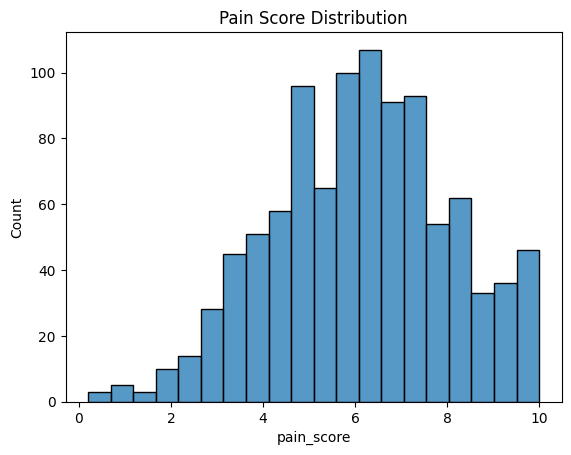

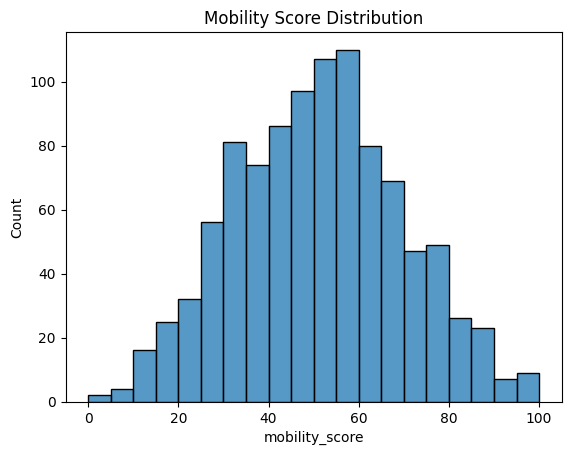

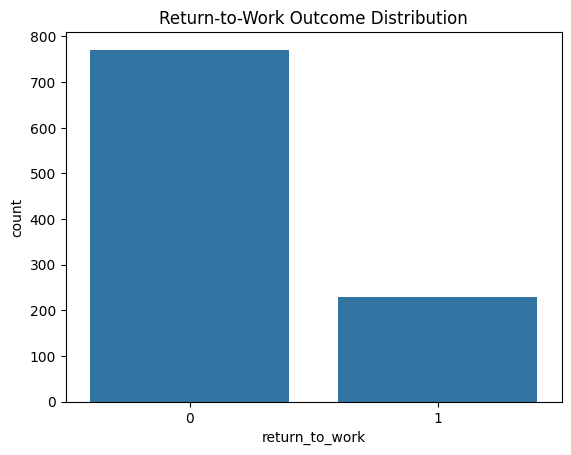

In [6]:
#visualize the key factors to ensure normal distribution.
sns.histplot(df['pain_score'], bins=20)
plt.title("Pain Score Distribution")
plt.show()

sns.histplot(df['mobility_score'], bins=20)
plt.title("Mobility Score Distribution")
plt.show()

sns.countplot(x='return_to_work', data=df)
plt.title("Return-to-Work Outcome Distribution")
plt.show()


In [7]:
#reloading the dataset
df = pd.read_csv("../data/low_back_pain_rtw_dataset.csv")
df.head()


,age,pain_score,mobility_score,work_status,job_type,psychosocial_risk,return_to_work
0,56,2.7,96.9,Not Working,Manual,4.3,0
1,46,6.1,66.7,Modified Duty,Sedentary,8.4,0
2,32,6.5,43.0,Modified Duty,Sedentary,4.5,0
3,60,4.2,55.3,Modified Duty,Sedentary,5.6,0
4,25,7.3,43.2,Full Duty,Sedentary,7.9,0


In [8]:
#overview of dataframe structure
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1000 non-null   int64  
 1   pain_score         1000 non-null   float64
 2   mobility_score     1000 non-null   float64
 3   work_status        1000 non-null   object 
 4   job_type           1000 non-null   object 
 5   psychosocial_risk  1000 non-null   float64
 6   return_to_work     1000 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


,age,pain_score,mobility_score,psychosocial_risk,return_to_work
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,41.575000,6.139300,51.02070,4.929300,0.229000
std,13.765677,1.950372,18.62034,2.369943,0.420399
min,18.000000,0.200000,0.00000,0.000000,0.000000
25%,30.000000,4.800000,37.65000,3.300000,0.000000
50%,42.000000,6.100000,51.30000,5.000000,0.000000
75%,53.000000,7.400000,63.60000,6.600000,0.000000
max,65.000000,10.000000,100.00000,10.000000,1.000000


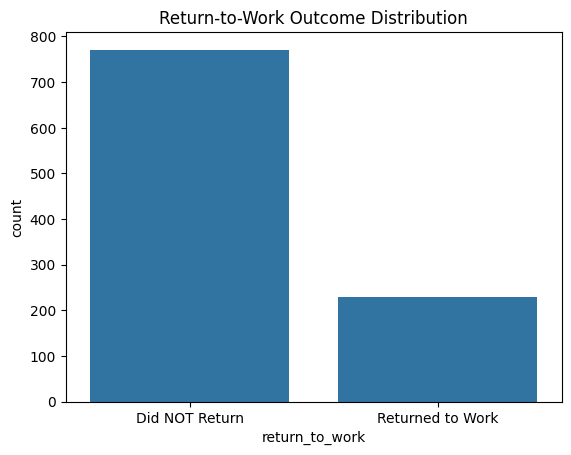

In [9]:
#visualizing the distribution of return to work outcomes
sns.countplot(x="return_to_work", data=df)
plt.title("Return-to-Work Outcome Distribution")
plt.xticks([0, 1], ["Did NOT Return", "Returned to Work"])
plt.show()


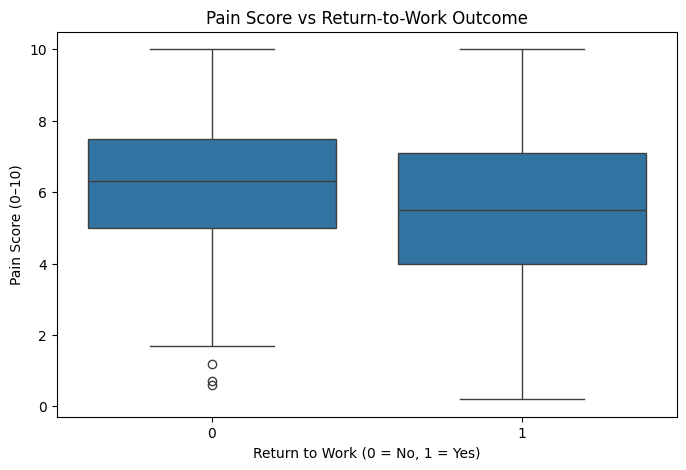

In [10]:
#visualizing pain vs RTW
plt.figure(figsize=(8,5))
sns.boxplot(x="return_to_work", y="pain_score", data=df)
plt.title("Pain Score vs Return-to-Work Outcome")
plt.xlabel("Return to Work (0 = No, 1 = Yes)")
plt.ylabel("Pain Score (0–10)")
plt.show()


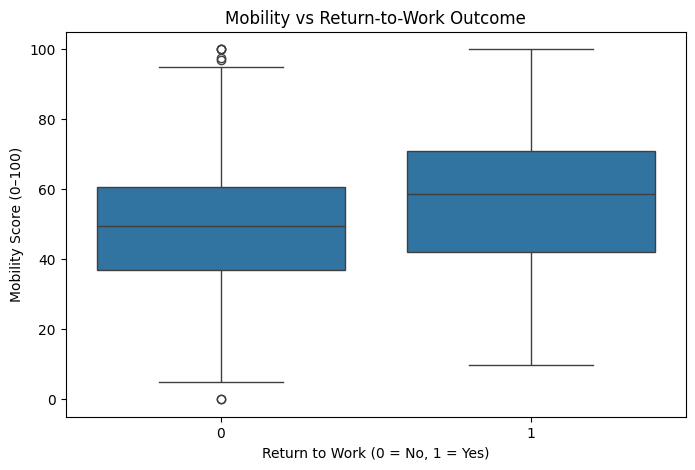

In [11]:
#visualizing mobility score and RTW
plt.figure(figsize=(8,5))
sns.boxplot(x="return_to_work", y="mobility_score", data=df)
plt.title("Mobility vs Return-to-Work Outcome")
plt.xlabel("Return to Work (0 = No, 1 = Yes)")
plt.ylabel("Mobility Score (0–100)")
plt.show()


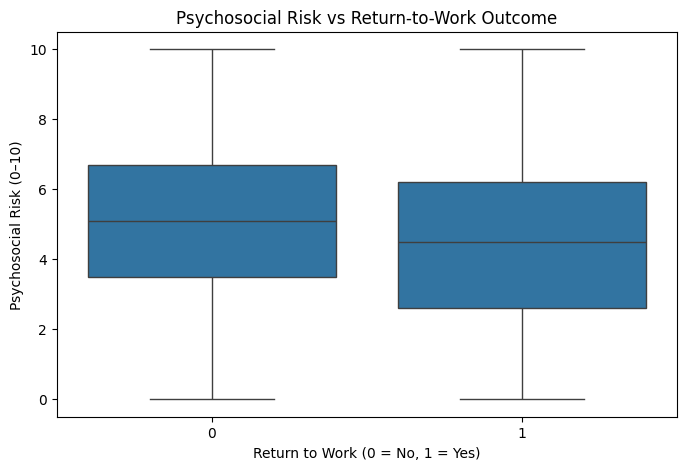

In [12]:
#viualizing psychosocial factors and RTW
plt.figure(figsize=(8,5))
sns.boxplot(x="return_to_work", y="psychosocial_risk", data=df)
plt.title("Psychosocial Risk vs Return-to-Work Outcome")
plt.xlabel("Return to Work (0 = No, 1 = Yes)")
plt.ylabel("Psychosocial Risk (0–10)")
plt.show()


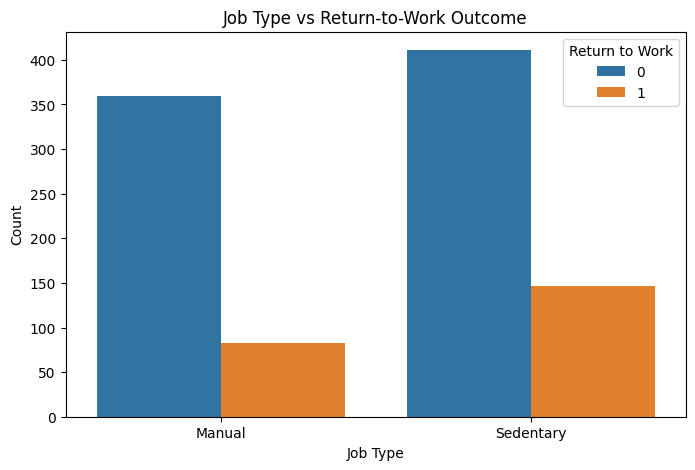

In [13]:
#visualizing RTW outcomes of sedentary vs manual work:
plt.figure(figsize=(8,5))
sns.countplot(x="job_type", hue="return_to_work", data=df)
plt.title("Job Type vs Return-to-Work Outcome")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.legend(title="Return to Work")
plt.show()
 

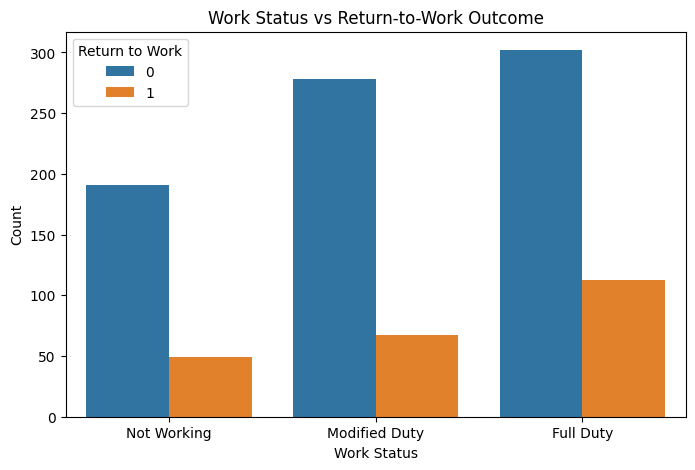

In [14]:
#visualizing current work status and RTW outcomes
plt.figure(figsize=(8,5))
sns.countplot(x="work_status", hue="return_to_work", data=df)
plt.title("Work Status vs Return-to-Work Outcome")
plt.xlabel("Work Status")
plt.ylabel("Count")
plt.legend(title="Return to Work")
plt.show()


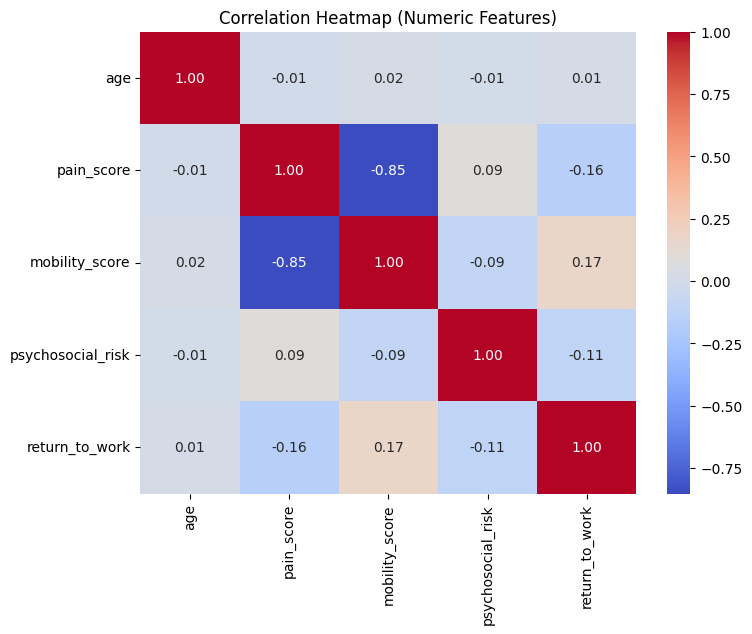

In [15]:
#visualizing the features in a heatmap
plt.figure(figsize=(8,6))

numeric_df = df[['age', 'pain_score', 'mobility_score', 'psychosocial_risk', 'return_to_work']]
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


# Exploratory Data Analysis Insights:

1. Higher pain scores are associated with lower return-to-work rates

2. Higher mobility increases the probability of successful return-to-work.

3. Psychosocial risk shows a negative relationship with return-to-work.

4. Manual job type is associated with reduced return-to-work success

5. Patients who are not working at intake are the highest-risk group

These patterns align with established occupational rehabilitation literature, supporting the clinical realism of this synthetic dataset.

# Machine Learning Pre-processing

In [16]:

# Load dataset
df = pd.read_csv("../data/low_back_pain_rtw_dataset.csv")

# Features (X) and target (y)
X = df.drop("return_to_work", axis=1)
y = df["return_to_work"]

print(X.shape)
print(y.shape)


(1000, 6)
(1000,)


In [17]:
# Identify categorical and numerical columns
categorical_features = ["job_type", "work_status"]
numerical_features = ["age", "pain_score", "mobility_score", "psychosocial_risk"]

print("Categorical:", categorical_features)
print("Numerical:", numerical_features)


Categorical: ['job_type', 'work_status']
Numerical: ['age', 'pain_score', 'mobility_score', 'psychosocial_risk']


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(800, 6) (200, 6)


In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numeric_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

# Combine into one preprocessing object
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [20]:
# Fit only on training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform test data using same rules
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)

print("ML data is now clean, scaled, encoded, and ready for training.")


(800, 7)
(200, 7)
ML data is now clean, scaled, encoded, and ready for training.


# Baseline Logistic Regression Model

Test Accuracy: 0.775

Confusion Matrix:
 [[153   1]
 [ 44   2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       154
           1       0.67      0.04      0.08        46

    accuracy                           0.78       200
   macro avg       0.72      0.52      0.48       200
weighted avg       0.75      0.78      0.69       200

Baseline Logistic Regression Feature Importance
                     Feature  Coefficient
5  work_status_Modified Duty    -0.471742
4         job_type_Sedentary     0.389643
6    work_status_Not Working    -0.382226
2             mobility_score     0.314714
3          psychosocial_risk    -0.159439
0                        age     0.099957
1                 pain_score    -0.091435


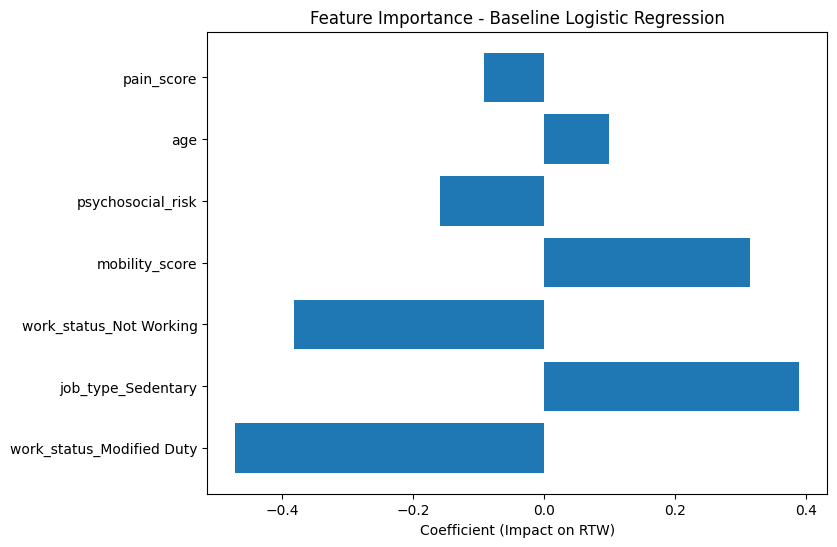

In [21]:

# Low Back Pain Return-to-Work Prediction
# Baseline Logistic Regression


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model
log_model = LogisticRegression(max_iter=1000, random_state=42)

#train
log_model.fit(X_train_processed, y_train)

#Testing
y_pred = log_model.predict(X_test_processed)

#Evaluation
#accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
#classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# categorical features
cat_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# numerical + encoded categorical features
all_features = np.concatenate([numerical_features, cat_features_encoded])

# model coefficients
coefficients = log_model.coef_[0]

# feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# print feature importance table
print("Baseline Logistic Regression Feature Importance")
print(feature_importance)

# visualization
plt.figure(figsize=(8,6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel("Coefficient (Impact on RTW)")
plt.title("Feature Importance - Baseline Logistic Regression")
plt.show()




#### Summary of Results & Clinical Interpretation of the Baseline Logistic Regression Model:
The baseline Logistic Regression model achieved an overall test accuracy of 0.78, but this performance was largely driven by strong prediction of the majority non–return-to-work class. While precision for return-to-work cases was moderate (0.67), sensitivity was low (recall = 0.04), indicating that the model failed to identify most true return-to-work patients and was heavily biased toward predicting non-return-to-work patients. 

Feature coefficient analysis showed that being on modified duty and not working were the strongest negative predictors of return to work, while having a sedentary job, greater mobility, and increasing age were positively associated with successful return. Psychosocial risk and pain score also showed negative associations with return-to-work outcomes. These relationships are clinically intuitive and align with established rehabilitation principles; however, the low recall highlights a critical limitation of using an unbalanced baseline model for return-to-work prediction.

# Balanced Logistic Regression Model

Test Accuracy (balanced): 0.59

Confusion Matrix:
 [[91 63]
 [19 27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.59      0.69       154
           1       0.30      0.59      0.40        46

    accuracy                           0.59       200
   macro avg       0.56      0.59      0.54       200
weighted avg       0.71      0.59      0.62       200

Balanced Logistic Regression Feature Importance
                     Feature  Coefficient
5  work_status_Modified Duty    -0.502096
4         job_type_Sedentary     0.402168
6    work_status_Not Working    -0.358262
2             mobility_score     0.322591
3          psychosocial_risk    -0.119773
0                        age     0.110577
1                 pain_score    -0.035530


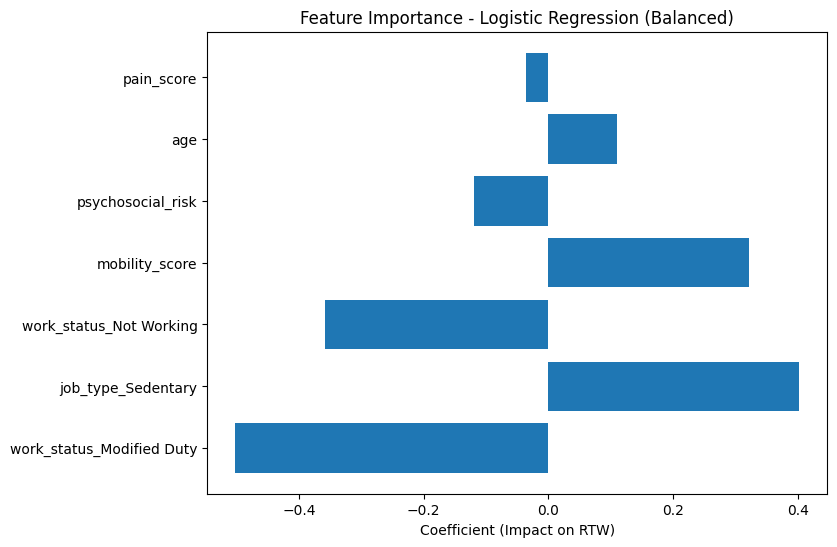

In [22]:

# Further Improving the Model: Adjust the Logistic Regression to Handle Class Imbalance


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model with balanced class weights
log_model_balanced = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

# Train
log_model_balanced.fit(X_train_processed, y_train)

#Test
y_pred_balanced = log_model_balanced.predict(X_test_processed)

#Evaluate
# Accuracy
print("Test Accuracy (balanced):", accuracy_score(y_test, y_pred_balanced))
# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))

# Feature coefficients
# feature names
cat_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numerical_features, cat_features_encoded])

# Coefficients
coefficients = log_model_balanced.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Balanced Logistic Regression Feature Importance")
print(feature_importance)

# Feature importance visualization 
plt.figure(figsize=(8,6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel("Coefficient (Impact on RTW)")
plt.title("Feature Importance - Logistic Regression (Balanced)")
plt.show()



#### Summary of Results & Clinical Interpretation of the Balanced Logistic Regression Model:

The balanced Logistic Regression model for predicting return-to-work (RTW) outcomes achieved a test accuracy of 0.59. While overall accuracy is lower than the unbalanced baseline logistic regression, adjusting for class imbalance substantially improved the model’s ability to identify patients who do return to work, increasing the recall for return-to-work patients from 0.04 to 0.59. The confusion matrix shows that the model correctly predicted 27 of 46 patients returning to work, while still maintaining reasonable performance in identifying non-return to work patients (91 of 154 correctly predicted). 

Feature coefficient analysis indicates that higher pain scores and psychosocial risk are associated with a lower likelihood of returning to work, whereas higher mobility, a sedentary job, and age are positively associated with RTW. Modified duties and not working statuses were negative predictors, consistent with clinical expectations. These findings align with rehabilitation principles, emphasizing the importance of functional capacity, psychosocial support, and tailored work arrangements in facilitating successful return-to-work outcomes.



# Random Forest Model

Random Forest Evaluation
Test Accuracy: 0.76

Confusion Matrix:
 [[150   4]
 [ 44   2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86       154
           1       0.33      0.04      0.08        46

    accuracy                           0.76       200
   macro avg       0.55      0.51      0.47       200
weighted avg       0.67      0.76      0.68       200

Random Forest Feature Importance
                     Feature  Coefficient
2             mobility_score     0.269648
3          psychosocial_risk     0.230902
1                 pain_score     0.216481
0                        age     0.194812
4         job_type_Sedentary     0.035308
5  work_status_Modified Duty     0.026854
6    work_status_Not Working     0.025994


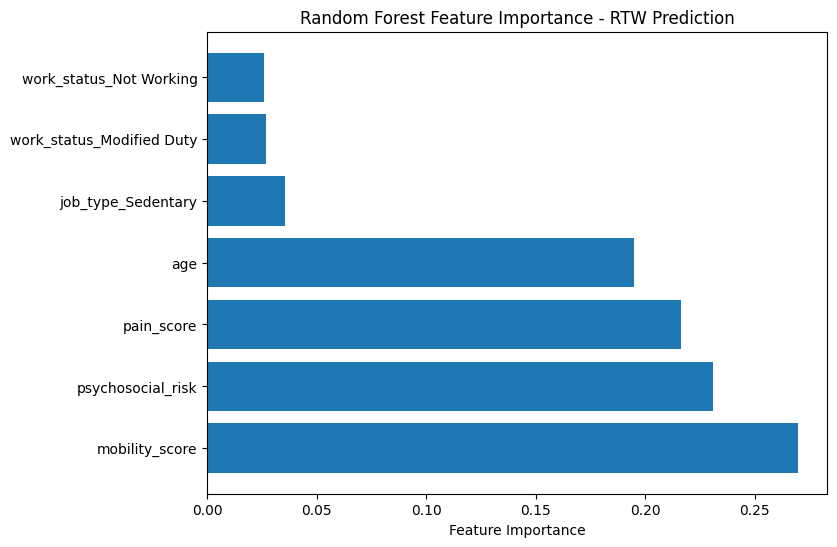

In [23]:

# Random Forest Model


# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Initialize Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    random_state=42,        
    class_weight='balanced'    # Handle class imbalance
)

# Train
rf_model.fit(X_train_processed, y_train)

# Test
y_pred_rf = rf_model.predict(X_test_processed)

# Evaluate
print("Random Forest Evaluation")
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Feature importance
importances = rf_model.feature_importances_

# Combine with feature names
feature_importance_rf = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': importances
}).sort_values(by='Coefficient', ascending=False)

print("Random Forest Feature Importance")
print(feature_importance_rf)

# Feature importance visualization
plt.figure(figsize=(8,6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Coefficient'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance - RTW Prediction")
plt.show()

#### Summary of Results & Clinical Interpretation of the Random Forest Model:

The Random Forest model for predicting return-to-work (RTW) outcomes achieved a test accuracy of 0.76. While overall accuracy is higher than the balanced Logistic Regression, the model performed poorly in identifying patients who actually return to work, with a recall of only 0.04. The confusion matrix shows that the model correctly predicted 2 of 46 patients returning-to-work, while accurately classifying most non-return-to-work patients (150 of 154 correctly predicted).

Feature importance analysis indicates that mobility, psychosocial risk, pain score, and age were the most influential predictors, whereas job type and work status had minimal impact. These results suggest that Random Forest captures the primary functional and psychosocial factors driving RTW outcomes but underrepresents work-related or occupational features. Clinically, this highlights the trade-off between overall predictive performance and the ability to detect minority-class patients, emphasizing the need to consider class imbalance when applying machine learning to rehabilitation predictions.

### Let's compare the balanced logistic regression and the random forest models


| Metric          | Logistic Regression (Baseline) | Logistic Regression (Balanced) | Random Forest |
| --------------- | ------------------------------ | ------------------------------ | ------------- |
| Test Accuracy   | 0.78                           | 0.59                           | 0.76          |
| Recall (RTW)    | 0.04                           | 0.59                           | 0.04          |
| Precision (RTW) | 0.67                           | 0.30                           | 0.33          |
| F1-score (RTW)  | 0.08                           | 0.40                           | 0.08          |



# Conclusion

In this project, baseline and balanced Logistic Regression models, along with a Random Forest classifier, were applied to predict return-to-work outcomes following low back pain rehabilitation. The baseline Logistic Regression achieved moderate overall accuracy (0.78) but largely failed to identify patients who actually returned to work (recall = 0.04), while balancing for class imbalance improved detection of the minority class (recall = 0.59) at the cost of overall accuracy (0.59). The Random Forest model achieved higher overall accuracy (0.76) but performed very poorly for return-to-work patients (recall = 0.04), demonstrating the challenge of minority-class prediction in imbalanced datasets. Across models, mobility, psychosocial risk, pain intensity, and age consistently emerged as the most influential predictors, whereas job type and work status were more important in Logistic Regression than in Random Forest. These findings highlight the trade-offs between predictive performance and clinical interpretability, and demonstrate how machine learning can integrate key clinical and functional variables to support rehabilitation decision-making.


# Limitations and Future Improvements:

This project represents a proof-of-concept and has several important limitations. The dataset used was synthetically generated and therefore does not fully reflect the complexity and variability of real-world rehabilitation populations. Future work should incorporate real clinical or workers’ compensation data to improve external validity and clinical relevance. Additionally, the current models rely only on static baseline features, whereas recovery following low back pain is dynamic; integrating longitudinal treatment and functional change data may substantially improve prediction performance.

Return-to-work was modeled as a binary outcome in this project, however, there are multiple outcomes in a real world setting. Expanding this framework to multi-class prediction would better align with real-world rehabilitation and case management needs. From a modeling perspective, future work will explore advanced ensemble methods such as gradient boosting and will prioritize external validation on an independent datasets to assess generalizability of the models.